## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

 - This Notebook aims to compute the MOC upper branch in the 34.5oS (SAMBAR) and compare the results with the observations. The upper branch is the integrated volume transport from the surface to the level where the meridional volume transport inverts.

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np  
import dask
import cf_xarray
import intake
import cftime
import nc_time_axis
import intake_esm
import matplotlib.pyplot as plt
import pop_tools
from dask.distributed import Client
from ncar_jobqueue import NCARCluster
import warnings, getpass, os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import cumtrapz
from scipy import integrate

## Dask

In [2]:
mem_per_worker = 20 # memory per worker in GB 
num_workers = 80 # number of workers
cluster = NCARCluster(cores=1, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB', walltime='6:00:00')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.25:44647' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.25:44647,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in OGCM history file & MOC template file

In [3]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [4]:
cat_subset = catalog.search(component='ocn',variable=['MOC'],frequency='month_1')

In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dset_dict_raw  = cat_subset.to_dataset_dict(zarr_kwargs={'consolidated': True}, storage_options={'anon': True})
print(f'\nDataset dictionary keys:\n {dset_dict_raw.keys()}')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



Dataset dictionary keys:
 dict_keys(['ocn.historical.pop.h.smbb.MOC', 'ocn.ssp370.pop.h.cmip6.MOC', 'ocn.ssp370.pop.h.smbb.MOC', 'ocn.historical.pop.h.cmip6.MOC'])


In [6]:
%%time
fb=('cmip6','smbb')
for ifb in range(0,2):
    print(f"Forcing_variant: {ifb}")
    str=f'ds_{fb[ifb]}_moc = dset_dict_raw[\'ocn.historical.pop.h.{fb[ifb]}.MOC\']' 
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.sel(time=slice(\'1850-01-01\', \'2014-12-31\'))' # Time Series
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.resample(time=\'1Y\', closed=\'left\').mean(\'time\')' # Yearly average
    exec(str)
    str=f'moc_{fb[ifb]} = ds_{fb[ifb]}_moc[\'MOC\']' # Variable
    exec(str)
    str=f'moc_{fb[ifb]}[\'moc_z\'] = -0.01*moc_{fb[ifb]}.moc_z' # +cm to -m 
    exec(str)

Forcing_variant: 0
Forcing_variant: 1
CPU times: user 9.55 s, sys: 46.8 ms, total: 9.59 s
Wall time: 9.78 s


### Concatenate cmip6 and smbb into a single xarray

In [7]:
ds_moc=xr.combine_nested([moc_cmip6,moc_smbb],concat_dim=['member_id']); del moc_cmip6, moc_smbb

### Let's take a look at the difference in MOC for different periods

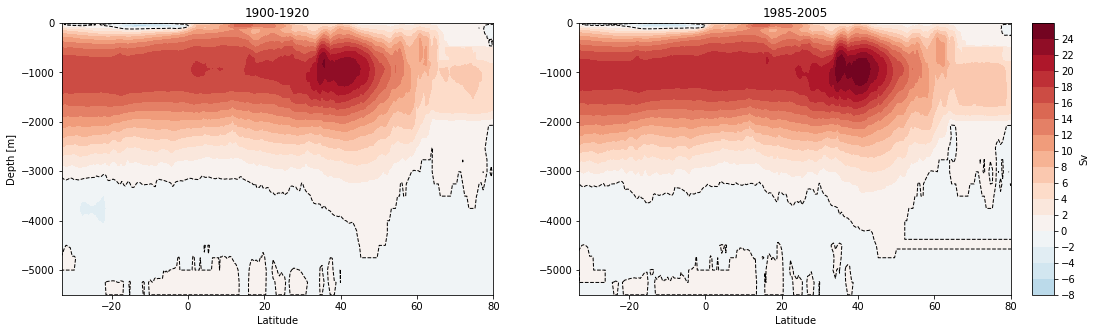

In [8]:
Z1 = ds_moc.isel(transport_reg=1).sel(time=slice('1900-01-01','1920-01-01')).mean(dim=['member_id','time']).sum(dim='moc_comp')
Z2 = ds_moc.isel(transport_reg=1).sel(time=slice('1985-01-01','2005-01-01')).mean(dim=['member_id','time']).sum(dim='moc_comp')
X, Y = np.meshgrid(ds_moc['lat_aux_grid'],ds_moc['moc_z'])
mn=-26
mx=26
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[17, 5])

im1 = ax1.contourf(X, Y, Z1, 20, vmin=mn, vmax=mx, cmap="RdBu_r")

axins = inset_axes(ax2,
                   width="5%",     # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
im = ax2.contourf(X, Y, Z2, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
fig.colorbar(im, cax=axins, ticks=range(mn, mx, 2),label='Sv')
ax1.contour(X, Y, Z1, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax2.contour(X, Y, Z2, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax1.set_title('1900-1920')
ax2.set_title('1985-2005')
ax1.set_xlabel('Latitude')
ax2.set_xlabel('Latitude')
ax1.set_ylabel('Depth [m]')
ax1.set_xlim(-33.008255,80)
ax2.set_xlim(-33.008255,80)
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> Notice that we limited the southernmost latitude (33.008255S) so that we could use the mask that covers the Atlantic
</div>

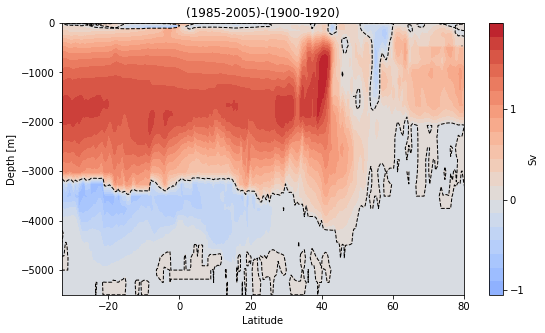

In [9]:
# Plot of the difference
fig, (ax3) = plt.subplots(figsize=(9, 5)) 
cs1 = ax3.contourf(X, Y, abs(Z2)-abs(Z1), 20, vmin=-2, vmax=2, cmap="coolwarm")
ax3.contour(X, Y, abs(Z2)-abs(Z1), levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax3.set_title('(1985-2005)-(1900-1920)')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Depth [m]')
ax3.set_xlim(-33.008255,80)
plt.colorbar(cs1,ticks=range(-2, 2),label='Sv')
plt.show()

### Hovmoller Diagrams (depth x time) for different MOC monitoring sections

In [10]:
%%time
# Compute a value to define a region of maximum in each section. 
Z1 = ds_moc.isel(transport_reg=1,lat_aux_grid=87).mean(dim='member_id').sum(dim='moc_comp')
Z1_max=np.sort(np.max(Z1, axis=0).values)[-4] # I chose a region of maximum, selecting the fourth maximum value of all the years
print(round(Z1_max,1))

Z2 = ds_moc.isel(transport_reg=1,lat_aux_grid=146).mean(dim='member_id').sum(dim='moc_comp')
Z2_max=np.sort(np.max(Z2, axis=0).values)[-4]
print(round(Z2_max,1))

Z3 = ds_moc.isel(transport_reg=1,lat_aux_grid=274).mean(dim='member_id').sum(dim='moc_comp')
Z3_max=np.sort(np.max(Z3, axis=0).values)[-4]
print(round(Z3_max,1))

Z4 = ds_moc.isel(transport_reg=1,lat_aux_grid=300).mean(dim='member_id').sum(dim='moc_comp')
Z4_max=np.sort(np.max(Z4, axis=0).values)[-4]
print(round(Z4_max,1))

X, Y = np.meshgrid(ds_moc['moc_z'],ds_moc['time'])

18.9
19.1
19.9
25.7
CPU times: user 1min 50s, sys: 1.84 s, total: 1min 52s
Wall time: 2min 2s


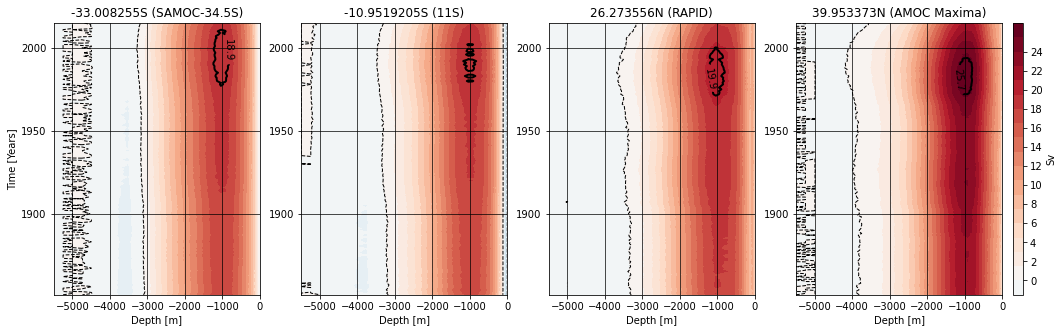

CPU times: user 5min 32s, sys: 5.74 s, total: 5min 38s
Wall time: 6min 7s


In [11]:
%%time
# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[17, 5])
ax1.contourf(X, Y, Z1, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
ax2.contourf(X, Y, Z2, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
ax3.contourf(X, Y, Z3, 20, vmin=mn, vmax=mx, cmap="RdBu_r")

im = ax4.contourf(X, Y, Z4, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
axins = inset_axes(ax4, width='5%', height='100%', loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax4.transAxes, borderpad=0)
fig.colorbar(im, cax=axins, ticks=range(mn, mx, 2),label='Sv')

# Subplots
fmax=10
ax1.contour(X, Y, Z1, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax1.contour(X, Y, Z1, levels = [18.9], colors=('k',), linestyles=('-',), linewidths=(2,))
ax1.clabel(CS, inline=True, fontsize=fmax); del CS

ax2.contour(X, Y, Z2, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax2.contour(X, Y, Z2, levels = [19.1], colors=('k',), linestyles=('-',), linewidths=(2,))
ax2.clabel(CS, inline=True, fontsize=fmax); del CS

ax3.contour(X, Y, Z3, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax3.contour(X, Y, Z3, levels = [19.9], colors=('k',), linestyles=('-',), linewidths=(2,))
ax3.clabel(CS, inline=True, fontsize=fmax); del CS

ax4.contour(X, Y, Z4, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax4.contour(X, Y, Z4, levels = [25.7], colors=('k',), linestyles=('-',), linewidths=(2,))
ax4.clabel(CS, inline=True, fontsize=fmax); del CS

#Labels
ax1.set_title('-33.008255S (SAMOC-34.5S)'); ax2.set_title('-10.9519205S (11S)'); ax3.set_title('26.273556N (RAPID)'); ax4.set_title('39.953373N (AMOC Maxima)')
ax1.set_xlabel('Depth [m]'); ax2.set_xlabel('Depth [m]'); ax3.set_xlabel('Depth [m]'); ax4.set_xlabel('Depth [m]')
ax1.set_ylabel('Time [Years]')
ax1.grid(color='k', linestyle='-', linewidth=0.7); ax2.grid(color='k', linestyle='-', linewidth=0.7); ax3.grid(color='k', linestyle='-', linewidth=0.7); ax4.grid(color='k', linestyle='-', linewidth=0.7)
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> From this figure it is clear that the recent weakening of the AMOC has a north-south direction. Would it be possible to determine the Lag between one latitude and another? Another exciting piece of information, the depth of the AMOC maximum does not seem to change over time; it stays at around 1000 meters at all latitudes, but the thickness of the upper branch changes. So when the MOC is stronger (weaker), the thickness of the upper branch is greater (less). 

### Let's do the same plot as before for some members of the same experiment, so we can see if the conclusion holds also when we look at the internal variability

In [29]:
%%time
# Compute a value to define a region of maximum in each section. 
Z1 = ds_moc.isel(transport_reg=1,lat_aux_grid=87).sel(member_id='r20i1231p1f2').sum(dim='moc_comp')
Z1_max=np.sort(np.max(Z1, axis=0).values)[-7] # I chose a region of maximum, selecting the fourth maximum value of all the years
print(round(Z1_max,1))

Z2 = ds_moc.isel(transport_reg=1,lat_aux_grid=146).sel(member_id='r20i1231p1f2').sum(dim='moc_comp')
Z2_max=np.sort(np.max(Z2, axis=0).values)[-7]
print(round(Z2_max,1))

Z3 = ds_moc.isel(transport_reg=1,lat_aux_grid=274).sel(member_id='r20i1231p1f2').sum(dim='moc_comp')
Z3_max=np.sort(np.max(Z3, axis=0).values)[-7]
print(round(Z3_max,1))

Z4 = ds_moc.isel(transport_reg=1,lat_aux_grid=300).sel(member_id='r20i1231p1f2').sum(dim='moc_comp')
Z4_max=np.sort(np.max(Z4, axis=0).values)[-7]
print(round(Z4_max,1))

X, Y = np.meshgrid(ds_moc['moc_z'],ds_moc['time'])

19.1
19.1
20.2
24.3
CPU times: user 3.66 s, sys: 57.1 ms, total: 3.71 s
Wall time: 5.47 s


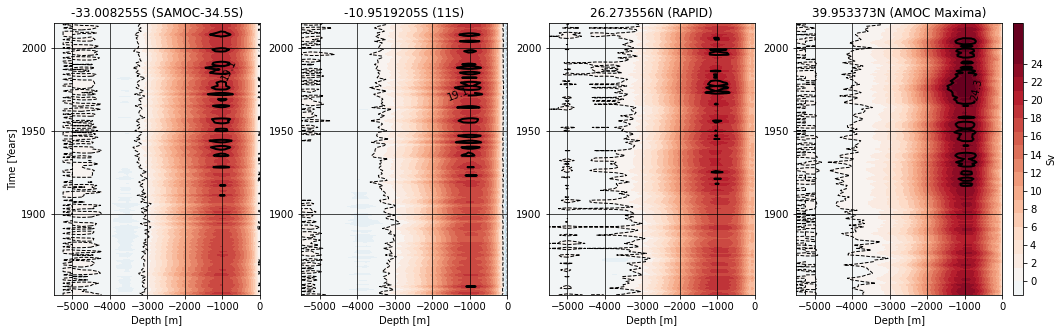

CPU times: user 10.6 s, sys: 172 ms, total: 10.8 s
Wall time: 15 s


In [30]:
%%time
# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[17, 5])
ax1.contourf(X, Y, Z1, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
ax2.contourf(X, Y, Z2, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
ax3.contourf(X, Y, Z3, 20, vmin=mn, vmax=mx, cmap="RdBu_r")

im = ax4.contourf(X, Y, Z4, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
axins = inset_axes(ax4, width='5%', height='100%', loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax4.transAxes, borderpad=0)
fig.colorbar(im, cax=axins, ticks=range(mn, mx, 2),label='Sv')

# Subplots
fmax=10
ax1.contour(X, Y, Z1, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax1.contour(X, Y, Z1, levels = [19.1], colors=('k',), linestyles=('-',), linewidths=(2,))
ax1.clabel(CS, inline=True, fontsize=fmax); del CS

ax2.contour(X, Y, Z2, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax2.contour(X, Y, Z2, levels = [19.1], colors=('k',), linestyles=('-',), linewidths=(2,))
ax2.clabel(CS, inline=True, fontsize=fmax); del CS

ax3.contour(X, Y, Z3, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax3.contour(X, Y, Z3, levels = [20.2], colors=('k',), linestyles=('-',), linewidths=(2,))
ax3.clabel(CS, inline=True, fontsize=fmax); del CS

ax4.contour(X, Y, Z4, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax4.contour(X, Y, Z4, levels = [24.3], colors=('k',), linestyles=('-',), linewidths=(2,))
ax4.clabel(CS, inline=True, fontsize=fmax); del CS

#Labels
ax1.set_title('-33.008255S (SAMOC-34.5S)'); ax2.set_title('-10.9519205S (11S)'); ax3.set_title('26.273556N (RAPID)'); ax4.set_title('39.953373N (AMOC Maxima)')
ax1.set_xlabel('Depth [m]'); ax2.set_xlabel('Depth [m]'); ax3.set_xlabel('Depth [m]'); ax4.set_xlabel('Depth [m]')
ax1.set_ylabel('Time [Years]')
ax1.grid(color='k', linestyle='-', linewidth=0.7); ax2.grid(color='k', linestyle='-', linewidth=0.7); ax3.grid(color='k', linestyle='-', linewidth=0.7); ax4.grid(color='k', linestyle='-', linewidth=0.7)
plt.show()

In [27]:
%%time
# Compute a value to define a region of maximum in each section. 
Z1 = ds_moc.isel(transport_reg=1,lat_aux_grid=87).sel(member_id='r20i1231p1f2').sum(dim='moc_comp')
Z1_max=np.sort(np.max(Z1, axis=0).values)[-7] # I chose a region of maximum, selecting the fourth maximum value of all the years
print(round(Z1_max,1))

Z2 = ds_moc.isel(transport_reg=1,lat_aux_grid=146).sel(member_id='r20i1231p1f2').sum(dim='moc_comp')
Z2_max=np.sort(np.max(Z2, axis=0).values)[-7]
print(round(Z2_max,1))

Z3 = ds_moc.isel(transport_reg=1,lat_aux_grid=274).sel(member_id='r20i1231p1f2').sum(dim='moc_comp')
Z3_max=np.sort(np.max(Z3, axis=0).values)[-7]
print(round(Z3_max,1))

Z4 = ds_moc.isel(transport_reg=1,lat_aux_grid=300).sel(member_id='r20i1231p1f2').sum(dim='moc_comp')
Z4_max=np.sort(np.max(Z4, axis=0).values)[-7]
print(round(Z4_max,1))

X, Y = np.meshgrid(ds_moc['moc_z'],ds_moc['time'])

19.1
19.1
20.2
24.3
CPU times: user 3.58 s, sys: 46.9 ms, total: 3.63 s
Wall time: 4.98 s


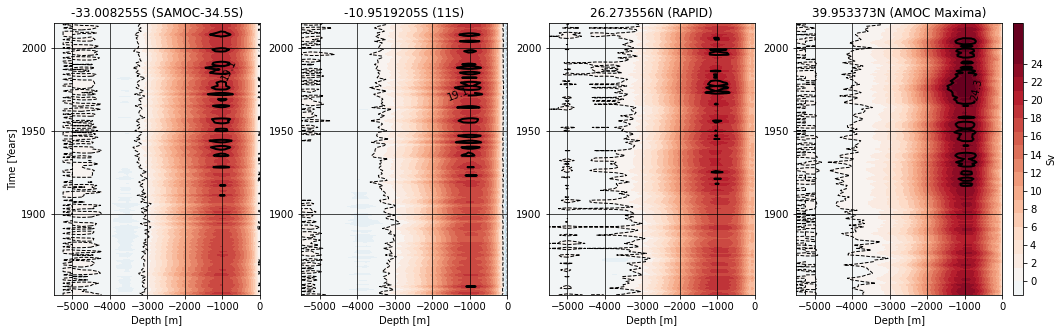

CPU times: user 10.7 s, sys: 171 ms, total: 10.9 s
Wall time: 15.1 s


In [28]:
%%time
# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[17, 5])
ax1.contourf(X, Y, Z1, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
ax2.contourf(X, Y, Z2, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
ax3.contourf(X, Y, Z3, 20, vmin=mn, vmax=mx, cmap="RdBu_r")

im = ax4.contourf(X, Y, Z4, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
axins = inset_axes(ax4, width='5%', height='100%', loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax4.transAxes, borderpad=0)
fig.colorbar(im, cax=axins, ticks=range(mn, mx, 2),label='Sv')

# Subplots
fmax=10
ax1.contour(X, Y, Z1, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax1.contour(X, Y, Z1, levels = [19.1], colors=('k',), linestyles=('-',), linewidths=(2,))
ax1.clabel(CS, inline=True, fontsize=fmax); del CS

ax2.contour(X, Y, Z2, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax2.contour(X, Y, Z2, levels = [19.1], colors=('k',), linestyles=('-',), linewidths=(2,))
ax2.clabel(CS, inline=True, fontsize=fmax); del CS

ax3.contour(X, Y, Z3, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax3.contour(X, Y, Z3, levels = [20.2], colors=('k',), linestyles=('-',), linewidths=(2,))
ax3.clabel(CS, inline=True, fontsize=fmax); del CS

ax4.contour(X, Y, Z4, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,)); CS=ax4.contour(X, Y, Z4, levels = [24.3], colors=('k',), linestyles=('-',), linewidths=(2,))
ax4.clabel(CS, inline=True, fontsize=fmax); del CS

#Labels
ax1.set_title('-33.008255S (SAMOC-34.5S)'); ax2.set_title('-10.9519205S (11S)'); ax3.set_title('26.273556N (RAPID)'); ax4.set_title('39.953373N (AMOC Maxima)')
ax1.set_xlabel('Depth [m]'); ax2.set_xlabel('Depth [m]'); ax3.set_xlabel('Depth [m]'); ax4.set_xlabel('Depth [m]')
ax1.set_ylabel('Time [Years]')
ax1.grid(color='k', linestyle='-', linewidth=0.7); ax2.grid(color='k', linestyle='-', linewidth=0.7); ax3.grid(color='k', linestyle='-', linewidth=0.7); ax4.grid(color='k', linestyle='-', linewidth=0.7)
plt.show()

In [12]:
del Z1, Z1_max, Z2, Z2_max, Z3, Z3_max, Z4, Z4_max, ax1, ax2, ax3, ax4, ds_moc

### Let's read the data again, as we need at least monthly series to compare with SAMOC (34.5S) which has daily series

In [16]:
fb=('cmip6','smbb')
for ifb in range(0,2):
    print(f"Forcing_variant: {ifb}")
    str=f'ds_{fb[ifb]}_moc = dset_dict_raw[\'ocn.historical.pop.h.{fb[ifb]}.MOC\']' 
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.sel(time=slice(\'2009-01-01\', \'2014-12-31\'))' # Time Series
    exec(str)
    str=f'ds_{fb[ifb]}_moc[\'moc_z\'] = -0.01*ds_{fb[ifb]}_moc[\'moc_z\']' # cm to m and negative depth
    exec(str)
    str=f'ds_{fb[ifb]}_moc[\'dz\'] = 0.01*ds_{fb[ifb]}_moc[\'dz\']' # cm to m and negative depth
    exec(str)

Forcing_variant: 0
Forcing_variant: 1


In [17]:
ds_moc=xr.combine_nested([ds_cmip6_moc,ds_smbb_moc],concat_dim=['member_id']); del ds_cmip6_moc, ds_smbb_moc

### What does the vertical profile of AMOC look like?

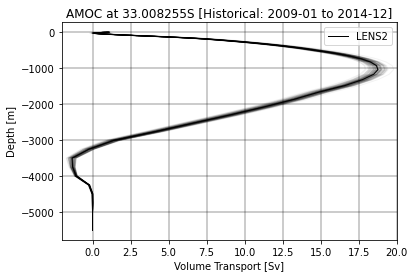

In [18]:
ila=87
alpha=0.05

moc_mean=ds_moc.MOC.isel(transport_reg=1,lat_aux_grid=ila).sum(dim='moc_comp').mean(dim='time')
moc_mean.plot.line(y='moc_z',color='black',alpha=alpha,linewidth=1,add_legend=False)
moc_mean.mean(dim='member_id').plot.line(y='moc_z',color='black',linewidth=1,label='LENS2')

plt.xlabel("Volume Transport [Sv]")
plt.ylabel("Depth [m]")
plt.title('AMOC at 33.008255S [Historical: 2009-01 to 2014-12]')
plt.grid(color='k', linestyle='-', linewidth=0.4)
bbox_props = dict(boxstyle='round', fc='w', ec='0.5', alpha=0.9)
plt.xlim(-2, 20)
plt.legend()
plt.show()

In [19]:
ds_moc.coords['lat_aux_grid'][ila]

<xarray.DataArray 'lat_aux_grid' ()>
array(-33.008255, dtype=float32)
Coordinates:
    lat_aux_grid  float32 -33.01
Attributes:
    long_name:  latitude grid for transport diagnostics
    units:      degrees_north
    valid_min:  -79.48815
    valid_max:  90.0

In [20]:
del moc_mean

### Interpolate to create AMOC data in the middle of the layer

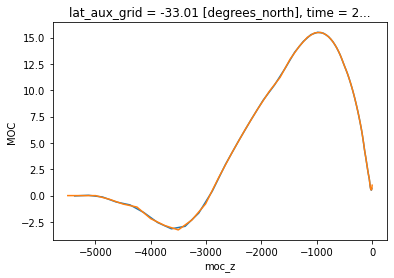

In [21]:
#cmip6
prof = np.empty((len(ds_moc['moc_z'])-1)) * np.nan
for t in range(0,len(ds_moc.coords['moc_z'])-1): 
        prof[t]=(ds_moc.coords['moc_z'][t]+ds_moc.coords['moc_z'][t+1])/2 
ds_moc.MOC.interp(moc_z=prof,method='cubic').isel(member_id=0,time=0,transport_reg=1,lat_aux_grid=ila).sum(dim='moc_comp').plot()
ds_moc.MOC.isel(member_id=0,time=0,transport_reg=1,lat_aux_grid=ila).sum(dim='moc_comp').plot()
ds_moc_int=ds_moc.interp(moc_z=prof,method='cubic')

In [19]:
%%time
#LENS2
y_int = np.empty((len(ds_moc_int['member_id']),len(ds_moc_int['time']))) * np.nan
for it in range(0,len(ds_moc_int['time'])): # time 
    print(f'Time: {it}')
    amoc = ds_moc_int.MOC.isel(time=it,transport_reg=1,lat_aux_grid=ila).sum(dim='moc_comp')
    for im in range(0,len(ds_moc_int['member_id'])): # members (50 member in total)
        #print(f'Member: {im}')
        L = np.where(amoc.isel(member_id=im,moc_z=slice(46,61))<0) # Notes: 40=-1041.3682m; 60=-5499.9907m
        if len(amoc['moc_z'][L])==0: # If there is no negative transport in this interval (moc_z=slice(46,61)), the integral is done from surface to bottom.     
            #y_int[it,im,ifb]=sum(amoc.isel(member_id=im,moc_z=slice(0,-1))*(amoc.isel(member_id=im)['moc_z'][0:-1].diff("moc_z")))/sum(amoc.isel(member_id=im)['moc_z'][0:-1].diff("moc_z"))
            y_int[im,it]=sum(amoc.isel(member_id=im)*ds_moc.dz.isel(member_id=im).values)/sum(ds_moc.dz.isel(member_id=im).values)
        else:
            #y_int[it,im,ifb]=sum(amoc.isel(member_id=im,moc_z=slice(0,L[0][0]-1+46))*(amoc.isel(member_id=im)['moc_z'][0:L[0][0]-1+46].diff('moc_z')))/sum(amoc.isel(member_id=im)['moc_z'][0:L[0][0]-1+46].diff('moc_z'))
            y_int[im,it]=sum(amoc.isel(member_id=im,moc_z=slice(0,L[0][0]-1+46))*ds_moc.dz.isel(member_id=im)[0:L[0][0]-1+46].values)/sum(ds_moc.dz.isel(member_id=im)[0:L[0][0]-1+46].values)

<timed exec>:2: RuntimeWarning: invalid value encountered in multiply


Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time: 20
Time: 21
Time: 22
Time: 23
Time: 24
Time: 25
Time: 26
Time: 27
Time: 28
Time: 29
Time: 30
Time: 31
Time: 32
Time: 33
Time: 34
Time: 35
Time: 36
Time: 37
Time: 38
Time: 39
Time: 40
Time: 41
Time: 42
Time: 43
Time: 44
Time: 45
Time: 46
Time: 47
Time: 48
Time: 49
Time: 50
Time: 51
Time: 52
Time: 53
Time: 54
Time: 55
Time: 56
Time: 57
Time: 58
Time: 59
Time: 60
Time: 61
Time: 62
Time: 63
Time: 64
Time: 65
Time: 66
Time: 67
Time: 68
Time: 69
Time: 70
Time: 71
CPU times: user 1h 38min 37s, sys: 1min 14s, total: 1h 39min 51s
Wall time: 4h 1min 50s


In [21]:
ds_MOC_SAMOC = xr.Dataset({'MOC_SAMOC': (('member_id','time'), y_int)},coords={'member_id': ds_moc.coords['member_id'],'time': ds_moc.coords['time']})
ds_MOC_SAMOC.attrs['description'] = 'Meridional Overturning Circulation (MOC) upper branch from the surface to the level where the transport volume reverses sign for the period from 2009 to 2014'
ds_MOC_SAMOC.attrs['units'] = 'Sv'
ds_MOC_SAMOC.attrs['author'] = 'Mauricio Rocha'
ds_MOC_SAMOC.attrs['email'] = 'mauricio.rocha@usp.br'
ds_MOC_SAMOC['time'] = ds_MOC_SAMOC['time'].astype('datetime64[ns]')

In [22]:
# create a directory on scratch to save the output
path = '/glade/scratch/mauricio/LENS2_historical_south_atlantic/MOC_SAMOC/'.format(getpass.getuser())
os.system('mkdir -p '+path)
ds_MOC_SAMOC.to_netcdf(path+'MOC_SAMOC.nc')

In [23]:
import scipy.io
samoc_obs = scipy.io.loadmat('/glade/scratch/mauricio/SAMOC/Data/moc_sambar.mat')
samoc_moc = samoc_obs['moc'][:,0]
samoc_jd = samoc_obs['jd']-719529
timexr = pd.date_range("2009-03-18", periods=len(samoc_jd))
reference_time = pd.Timestamp("2009-03-17")
ds = xr.Dataset({'SAMOC': xr.DataArray(data=samoc_moc,dims=['time'],coords = {'time': timexr})})
ds_mean=ds.sel(time=slice('2009-03-18','2014-12-31')).resample(time='1M').mean('time')
ds_mean['time'] = ds_MOC_SAMOC['time'][2:]

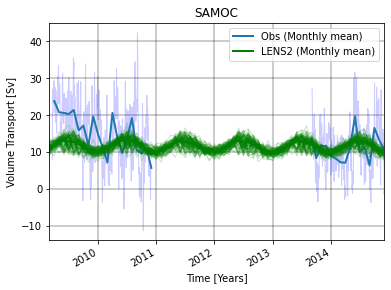

Obs Mean: 13.4
LENS2 Mean: 11.6
RMSE: 4.9


In [24]:
ds.SAMOC.sel(time=slice('2009-03-18','2014-12-31')).plot.line(x='time',color='blue',alpha=0.2,linewidth=1,add_legend=False)
ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')).plot.line(x='time',linewidth=2,label='Obs (Monthly mean)')
ds_MOC_SAMOC.MOC_SAMOC.sel(time=slice('2009-03-01','2014-12-01')).plot.line(x="time",color='green',alpha=0.2,linewidth=1,add_legend=False)
ds_MOC_SAMOC.MOC_SAMOC.sel(time=slice('2009-03-01','2014-12-01')).mean(dim='member_id').plot.line(x="time",color='green',linewidth=2,label='LENS2 (Monthly mean)')
plt.ylabel("Volume Transport [Sv]")
plt.xlabel("Time [Years]")
plt.title("SAMOC")
plt.grid(color='k', linestyle='-', linewidth=0.4)
plt.xlim(ds_mean['time'][0], ds_mean['time'][-1])
#plt.ylim(5,25)
plt.legend()
plt.show()
obs_mean=mean=np.nanmean(ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')))
LENS2_mean=np.nanmean(ds_MOC_SAMOC.MOC_SAMOC.sel(time=slice('2009-03-01','2014-12-01')).mean(dim=['member_id']))
RMSE=((ds_MOC_SAMOC.MOC_SAMOC.sel(time=slice('2009-03-01','2014-12-01')).mean(dim=['member_id'])-ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')))**2).mean()**0.5
print(f"Obs Mean: {np.round(obs_mean,1)}")
print(f"LENS2 Mean: {np.round(LENS2_mean,1)}")
print(f"RMSE: {np.round(RMSE,1)}")

<div class="alert alert-block alert-info">
<b>Note:</b> The figure above clearly shows that LENS2 produces a smoother AMOC than reality. The difference between the observation and the large ensemble in the SAMOC line was around 2Sv, similarly to that of Rodgers et al. (2021) for the RAPID section: https://esd.copernicus.org/articles/12/1393/2021/

### Let's compute the mean square error for each member and evaluate which member came closest to the observation (the smallest error)

In [25]:
for im in range(0,len(ds_MOC_SAMOC['member_id'])): # members (50 member in total)
    RMSE_=((ds_MOC_SAMOC.MOC_SAMOC.isel(member_id=im).sel(time=slice('2009-03-01','2014-12-01'))-ds_mean.SAMOC.sel(time=slice('2009-03-1','2014-12-31')))**2).mean()**0.5
    #print(ds_MOC_SAMOC.MOC_SAMOC.coords['member_id'][im].values,f' RMSE: {np.round(RMSE,2)[im]}')

<function matplotlib.pyplot.show(close=None, block=None)>

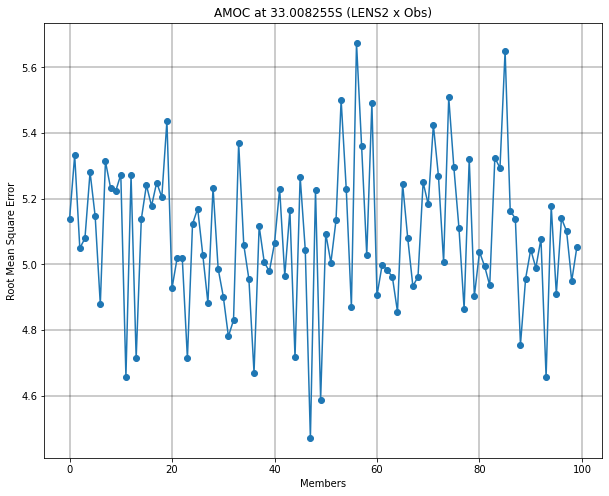

In [27]:
RMSE = np.empty((len(ds_MOC_SAMOC['member_id']))) * np.nan
for im in range(0,len(ds_MOC_SAMOC['member_id'])): # members (50 member in total)
    RMSE[im]=((ds_MOC_SAMOC.MOC_SAMOC.isel(member_id=im).sel(time=slice('2009-03-01','2014-12-01'))-ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')))**2).mean()**0.5
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(RMSE,'-o')
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("Members")
ax.set_title("AMOC at 33.008255S (LENS2 x Obs)")
ax.grid(color='k', linestyle='-', linewidth=0.4)
plt.show